<a href="https://colab.research.google.com/github/moyothandiwe/moondancer/blob/main/Web_Analytics_Project.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Group members:**

luis.rinconjaimes@edhec.com

thandiwe.moyo@edhec.com

tanzeelahmed.shaik@edhec.com

santanukumar.pal@edhec.com


# **Setting up and accessing the big query dataset**

In [ ]:
import pandas as pd
from google.colab import auth
from google.cloud import bigquery

auth.authenticate_user()

In [ ]:
project_id = "main-crow-418809"


## **Importing relevant libraries for data visualizations & statistical tests**

In [ ]:
import matplotlib.pyplot as plt
import scipy.stats as stats
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns

## **Business Problem 1: Which subregion generated the most sales at the end of January?**

In [ ]:
# Define the SQL query to identify the subregion with the highest sales for January 30th and 31st
query = """
SELECT
  geo.sub_continent AS subregion,
  SUM(ecommerce.purchase_revenue_in_usd) AS total_revenue,
  RANK() OVER (ORDER BY SUM(ecommerce.purchase_revenue_in_usd) DESC) AS rank
FROM
  `bigquery-public-data.ga4_obfuscated_sample_ecommerce.events_202101*`
WHERE
  event_date IN ('20210130', '20210131')
GROUP BY
  subregion
ORDER BY
  total_revenue DESC
"""

client = bigquery.Client(project=project_id)
query_job = client.query(query)

# Run the query and load the results into a Pandas DataFrame
df = client.query(query).to_dataframe()

# Display the DataFrame for verification
df.head()

,subregion,total_revenue,rank
0,Northern America,114.0,1
1,South America,28.0,2
2,Eastern Asia,17.0,3
3,Southeast Asia,0.0,4
4,Western Europe,0.0,4


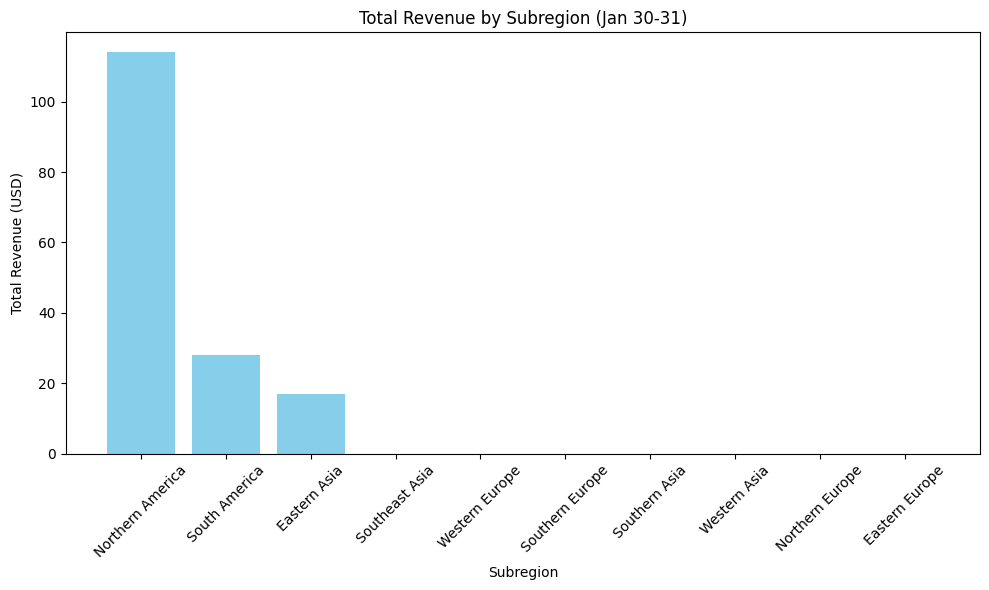

In [ ]:
# Assuming 'df' is your DataFrame containing the query result
# Plot the bar chart
plt.figure(figsize=(10, 6))
plt.bar(df['subregion'], df['total_revenue'], color='skyblue')
plt.xlabel('Subregion')
plt.ylabel('Total Revenue (USD)')
plt.title('Total Revenue by Subregion (Jan 30-31)')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

## **Business Problem 2: Test the assumption that the subregion with the highest sales in the subregion also saw the most user engagement at the end of the month**

In [ ]:
query = """

SELECT
  geo.sub_continent AS subregion,
  SUM(ecommerce.purchase_revenue_in_usd) AS total_sales,
  COUNTIF(event_name = 'user_engagement') AS user_engagement_count
FROM
  `bigquery-public-data.ga4_obfuscated_sample_ecommerce.events_202101*`
WHERE
  event_date IN ('20210130', '20210131')
GROUP BY
  subregion
ORDER BY
  total_sales DESC

"""

# Load query results into a DataFrame
df = client.query(query).to_dataframe()

# Remove rows with infinite or NaN values in the relevant columns
df = df[np.isfinite(df['total_sales']) & np.isfinite(df['user_engagement_count'])]

# Perform Pearson correlation test
correlation, p_value = stats.pearsonr(df['total_sales'], df['user_engagement_count'])

# Print results
print(f"Pearson Correlation Coefficient: {correlation}")
print(f"P-Value: {p_value}")

# Interpret results
if p_value < 0.05:
    print("The correlation is statistically significant, our assumption is therefore true.")
else:
    print("The correlation is not statistically significant, our assumption is therefore false.")

Pearson Correlation Coefficient: 0.9475738019876355
P-Value: 3.101585928048862e-05
The correlation is statistically significant, our assumption is therefore true.


## **Business Problem 3: In which day did the website get the most views?**

In [ ]:
query = """
SELECT
  event_date,
  COUNTIF(event_name = 'page_view') AS page_view_count
FROM
  `bigquery-public-data.ga4_obfuscated_sample_ecommerce.events_202101*`
GROUP BY
  event_date
ORDER BY
  page_view_count DESC
"""

# Load query results into a DataFrame
df = client.query(query).to_dataframe()

# Find the date with the highest number of page views
max_date = df.loc[df['page_view_count'].idxmax()]
print(f"The date with the highest number of page views is {max_date['event_date']} with {max_date['page_view_count']} views.")

The date with the highest number of page views is 20210120 with 21007 views.


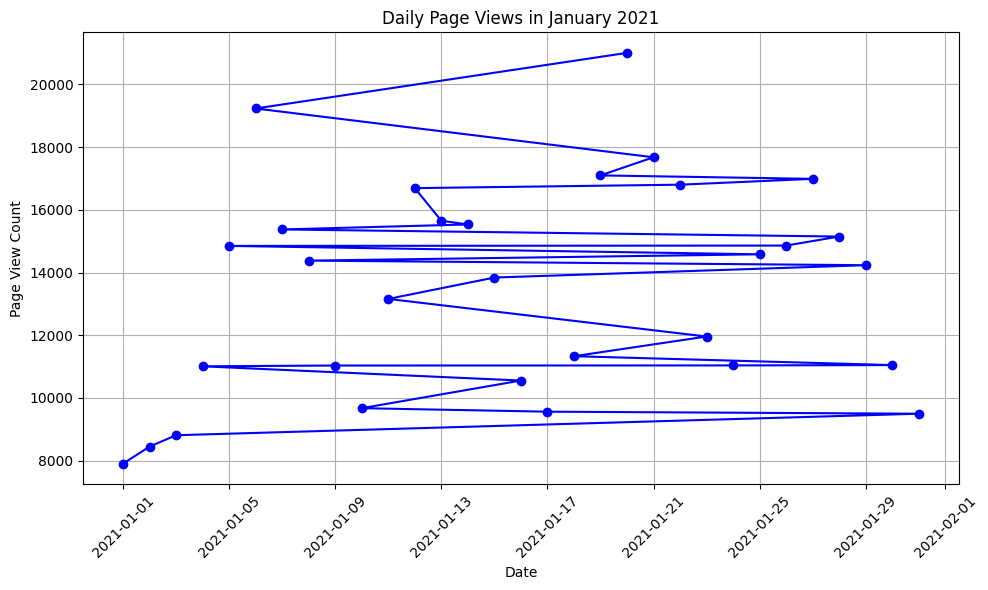

In [ ]:
# Convert event_date to datetime for better plotting
df['event_date'] = pd.to_datetime(df['event_date'], format='%Y%m%d')

# Plot daily page views
plt.figure(figsize=(10, 6))
plt.plot(df['event_date'], df['page_view_count'], marker='o', linestyle='-', color='blue')
plt.title('Daily Page Views in January 2021')
plt.xlabel('Date')
plt.ylabel('Page View Count')
plt.grid(True)
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


## **Business Problem 4: Rank European countries by website visits through mobile devices**

In [ ]:
query = """
SELECT
  geo.country AS country,
  COUNT(*) AS mobile_visits,
  RANK() OVER (ORDER BY COUNT(*) DESC) AS rank
FROM
  `bigquery-public-data.ga4_obfuscated_sample_ecommerce.events_202101*`
WHERE
  device.category = 'mobile'
  AND geo.continent = 'Europe'
GROUP BY
  country
ORDER BY
  mobile_visits DESC
"""

# Load query results into a DataFrame
df = client.query(query).to_dataframe()

# Display the top 10 countries
top_10_countries = df.head(10)
print(top_10_countries)

          country  mobile_visits  rank
0  United Kingdom          16087     1
1           Spain           9305     2
2         Germany           8566     3
3          France           8062     4
4     Netherlands           6393     5
5           Italy           6123     6
6          Poland           3965     7
7          Russia           3146     8
8          Sweden           2953     9
9     Switzerland           2771    10


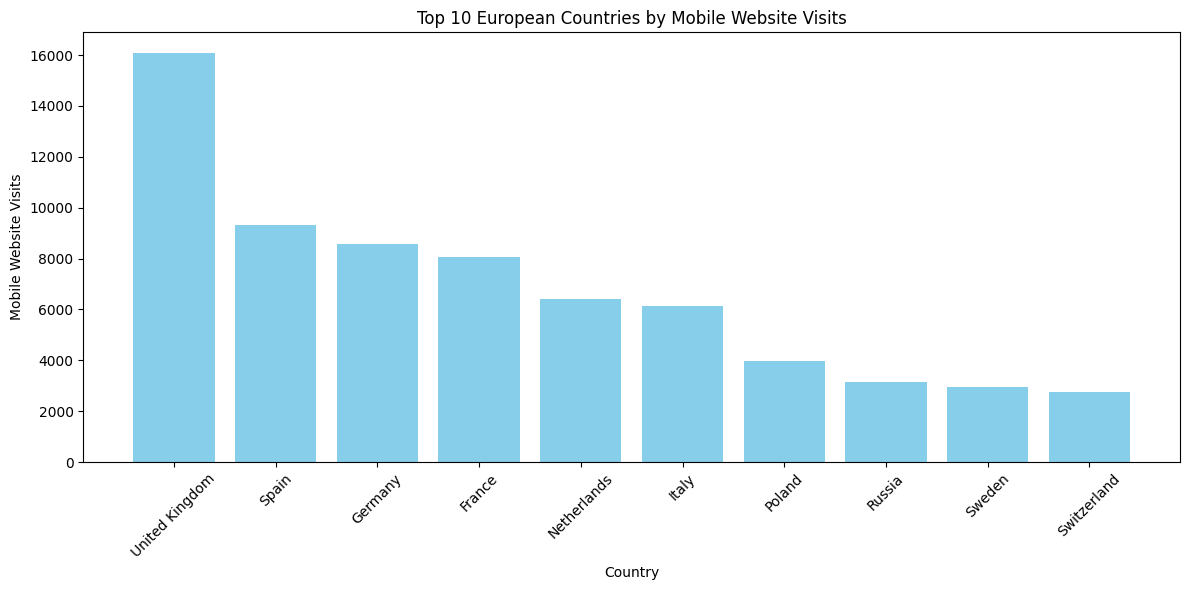

In [ ]:
# Plot top 10 countries
plt.figure(figsize=(12, 6))
plt.bar(top_10_countries['country'], top_10_countries['mobile_visits'], color='skyblue')
plt.title('Top 10 European Countries by Mobile Website Visits')
plt.xlabel('Country')
plt.ylabel('Mobile Website Visits')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

## **Business Problem 5: Test the assumption that the top 3 European countries with the most website visits also generated top sales within Europe for the month of January**

In [ ]:
query="""
WITH CountryVisits AS (
  SELECT
    geo.country AS country,
    COUNT(*) AS total_visits,
    SUM(ecommerce.purchase_revenue_in_usd) AS total_sales
  FROM
    `bigquery-public-data.ga4_obfuscated_sample_ecommerce.events_202101*`
  WHERE
    geo.continent = 'Europe'
  GROUP BY
    country
  ORDER BY
    total_visits DESC
  LIMIT 3
)
SELECT
  country,
  total_visits,
  total_sales
FROM
  CountryVisits
ORDER BY
  total_visits DESC
"""

# Load query results into a DataFrame
df = client.query(query).to_dataframe()

# Perform Pearson correlation test
correlation, p_value = stats.pearsonr(df['total_visits'], df['total_sales'])

# Print results
print(f"Pearson Correlation Coefficient: {correlation}")
print(f"P-Value: {p_value}")

# Interpret results
if p_value < 0.05:
    print("The correlation is statistically significant, our assumption is therefore true.")
else:
    print("The correlation is not statistically significant, our assumption is therefore not true.")

Pearson Correlation Coefficient: 0.7817384672440757
P-Value: 0.42866639370641246
The correlation is not statistically significant, our assumption is therefore not true.


## **Business Problem 6: Which marketing channel generated the highest revenue?**

In [ ]:
query = """
SELECT
  traffic_source.medium AS channel,
  SUM(ecommerce.purchase_revenue_in_usd) AS total_revenue,
  ROUND(SUM(ecommerce.purchase_revenue_in_usd) / SUM(SUM(ecommerce.purchase_revenue_in_usd)) OVER () * 100, 2) AS revenue_percentage,
  RANK() OVER (ORDER BY SUM(ecommerce.purchase_revenue_in_usd) DESC) AS rank
FROM
  `bigquery-public-data.ga4_obfuscated_sample_ecommerce.events_202101*`
WHERE
  ecommerce.purchase_revenue_in_usd IS NOT NULL
GROUP BY
  channel
ORDER BY
  total_revenue DESC
"""

# Execute the query and load the results into a Pandas DataFrame
df = client.query(query).to_dataframe()

# Display the top channels by revenue
print(df)

          channel  total_revenue  revenue_percentage  rank
0         organic        16940.0               29.54     1
1        referral        14153.0               24.68     2
2          (none)        12284.0               21.42     3
3  (data deleted)         6164.0               10.75     4
4         <Other>         5970.0               10.41     5
5             cpc         1839.0                3.21     6


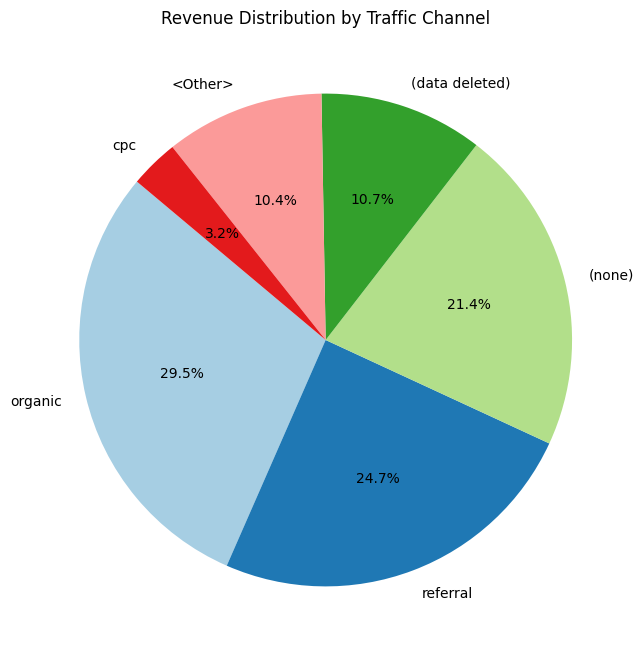

In [ ]:
# Plot pie chart
plt.figure(figsize=(8, 8))
plt.pie(df['total_revenue'], labels=df['channel'], autopct='%1.1f%%', startangle=140, colors=plt.cm.Paired.colors)
plt.title('Revenue Distribution by Traffic Channel')
plt.show()

## **Business Problem 7: Test the assumption that the difference between average revenue per session by device types **

In [ ]:
query = """
SELECT
  device.category AS device_type,
  AVG(ecommerce.purchase_revenue_in_usd) AS avg_revenue_per_session,
  COUNT(*) AS session_count
FROM
  `bigquery-public-data.ga4_obfuscated_sample_ecommerce.events_202101*`
WHERE
  ecommerce.purchase_revenue_in_usd IS NOT NULL
GROUP BY
  device_type
ORDER BY
  avg_revenue_per_session DESC
"""

# Load query results into a DataFrame
df = client.query(query).to_dataframe()

# Example data for statistical testing (for demonstration purposes)
# Group revenue data by device type
desktop_revenue = df[df['device_type'] == 'desktop']['avg_revenue_per_session']
mobile_revenue = df[df['device_type'] == 'mobile']['avg_revenue_per_session']
tablet_revenue = df[df['device_type'] == 'tablet']['avg_revenue_per_session']

# Perform ANOVA test
f_stat, p_value = stats.f_oneway(desktop_revenue, mobile_revenue, tablet_revenue)

# Print results
print(f"ANOVA F-Statistic: {f_stat}")
print(f"P-Value: {p_value}")

if p_value < 0.05:
    print("The differences in average revenue per session between device types are statistically significant.")
else:
    print("The differences in average revenue per session between device types are not statistically significant.")

ANOVA F-Statistic: nan
P-Value: nan
The differences in average revenue per session between device types are not statistically significant.


/usr/local/lib/python3.10/dist-packages/scipy/stats/_stats_py.py:4102: DegenerateDataWarning: all input arrays have length 1.  f_oneway requires that at least one input has length greater than 1.
  if _f_oneway_is_too_small(samples):


## **Business Problem 8: How does user engagement vary by subregion?**

In [ ]:
query = """
SELECT
  geo.sub_continent AS subregion,
  COUNTIF(event_name = 'user_engagement') AS engagement_events,
  COUNT(*) AS total_events,
  SAFE_DIVIDE(COUNTIF(event_name = 'user_engagement'), COUNT(*)) AS engagement_rate
FROM
  `bigquery-public-data.ga4_obfuscated_sample_ecommerce.events_202101*`
GROUP BY
  subregion
ORDER BY
  engagement_rate DESC
"""

# Execute the query and load the results into a Pandas DataFrame
df = client.query(query).to_dataframe()

df = df.dropna(subset=['engagement_rate'])

# Display the engagement rates for each subregion
print(df)

           subregion  engagement_events  total_events  engagement_rate
0    Northern Africa               1269          5964         0.212777
1    Central America               2718         12894         0.210796
2          (not set)                593          2838         0.208950
3       Western Asia               6811         32618         0.208811
4       Eastern Asia              17492         83810         0.208710
5    Northern Europe              12698         60934         0.208389
6      South America               6802         32811         0.207309
7      Southern Asia              24493        118231         0.207162
8        Australasia               2628         12689         0.207109
9     Southeast Asia              10131         48966         0.206899
10  Northern America             129004        625454         0.206257
11    Western Europe              15534         75410         0.205994
12   Southern Europe              11270         54915         0.205226
13    

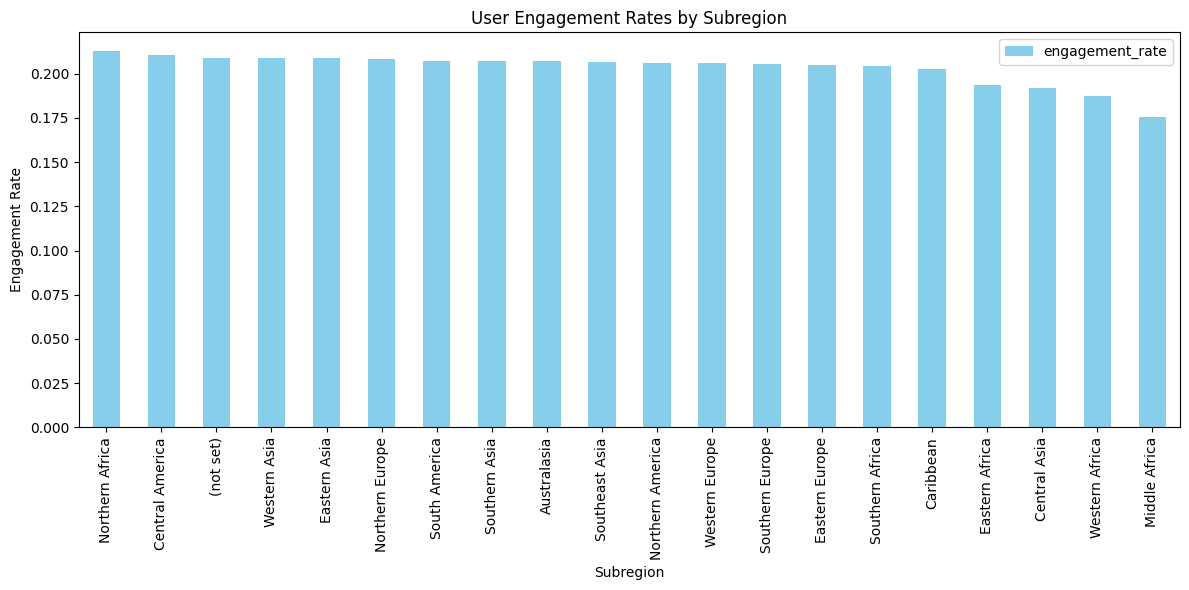

In [ ]:
df.sort_values('engagement_rate', ascending=False).plot(
    kind='bar', x='subregion', y='engagement_rate', figsize=(12, 6), color='skyblue'
)
plt.title("User Engagement Rates by Subregion")
plt.xlabel("Subregion")
plt.ylabel("Engagement Rate")
plt.tight_layout()
plt.show()


## **Appendix: Chat GPT prompts**

### Data exploration

*Help me explore the table schema in "bigquery-public-data.ga4_obfuscated_sample_ecommerce.events_20210123"*

*Is there a way to explore several schemas at once?*

*The data for several columns such as event_params, geo and ecommerce look confusing, how can I extract the nested data within these columns?*

*The data in event_params is still unreadable, unnest it further*

### Analysis of the dataset

*Identify the subregion (geo.sub_continent) with the highest sales (ecommerce.purchase_revenue_in_usd) for January 30th and 31st. Use SQL and provide a bar chart of revenue by subregion. If applicable, use a window function to rank subregions by sales.*

*Test if the subregion with the highest sales (geo.sub_continent) also had the highest user engagement (event_name = 'user_engagement') on January 30th and 31st. Perform a statistical test to validate the correlation. Visualize the relationship using a scatter plot or a comparative bar chart.*

*Find the date in January 2021 with the highest number of page views (event_name = 'page_view'). Use SQL to aggregate data and create a line chart showing daily page views.*

*Rank European countries (geo.country) by the number of website visits (event_name) generated through mobile devices (device.category = 'mobile'). Use SQL and include a window function for ranking. Provide a bar chart of top 10 countries.*

*Test if the top 3 European countries by website visits (event_name) also have the highest sales (ecommerce.purchase_revenue_in_usd) in January 2021. Perform a statistical test to validate the relationship. Include a grouped bar chart showing visits and sales for the top 3 countries.*

*Analyze traffic_source.medium to determine the channel (e.g., organic, referral, direct) with the highest revenue (ecommerce.purchase_revenue_in_usd). Use SQL and provide a pie chart of revenue distribution by channel. Use a window function to rank channels by revenue.*

*Calculate the average revenue (ecommerce.purchase_revenue_in_usd) per session for each device.category (desktop, mobile, tablet) in January 2021. Use SQL to aggregate data and include a statistical test to compare averages between device types. In addition, provide a box plot for revenue distribution by device type.*

*Analyze geo.sub_continent to compare user engagement (event_name = 'user_engagement'). Use SQL to count engagement events by subregion and calculate engagement rates as engagement events / total events. Visualize engagement rates using a heatmap or bar chart.*